<p style="text-align:center">
PSY 394U <b>Data Analytics with Python</b>, Spring 2019


<img style="width: 700px; padding: 0px;" src="https://github.com/sathayas/JupyterAnalyticsSpring2019/blob/master/Images/Banner.png?raw=true" alt="title pics"/>

</p>


<p style="text-align:center; font-size:40px; margin-bottom: 30px;"><b> Feature selection & cross validation </b></p>

<p style="text-align:center; font-size:18px; margin-bottom: 32px;"><b>March 7, 2019</b></p>

<hr style="height:5px;border:none" />

# 1. Feature selection
<hr style="height:1px;border:none" />

We talked about the curse of dimensionality in our previous class. To get around it, we can reduce the dimensionality of the data (e.g., PCA). Anther approach is to eliminate features that are not associated with the target, and to retain only those features that likely contribute classification of a data set, the process known as **feature selection**. There are a number of approaches for feature selection. The ones I present here are based on statistical principles, and may be familiar to most of you.

## Example: cryotherapy data

To demonstrate feature selection, we will examine the cryotherapy data again (**`Cryotherapy.csv`**). As you recall, there are 6 features in this data set, of which two are categorical (**`Sex`** and **`Type`**) and four are continuous (**`Age`**, **`Time`**, **`NumWarts`**, and **`Area`**). Here, we load the data and separate categorical and continuous features. 

`<CryoFeatures.py>`

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2, f_classif

# loading the data
CryoData = pd.read_csv('Cryotherapy.csv')

# features, categorical and continuous
xCat = CryoData[['Sex','Type']]
xCont = CryoData[['Age','Time','NumWarts','Area']]
y = CryoData.Success

### Categorical features

The association between a categorical feature and the target (a categorical variable) can be assessed by a $\chi^2$ test. The function **`chi2`** in **`sklearn.feature_selection`** can perform a $\chi^2$ test between each feature and the target. The `chi2` function requires two input parameters, the feature data array and the target labels. It returns 2 parameters; the first output parameter is an array of $\chi^2$ test statistics and the second output parameter is an array of corresponding p-values.

In [3]:
# categorical features
chiStat, chiP = chi2(xCat,y)
print(chiP)

[0.73684818 0.00149219]


Here, you can see that the feature `Type` is highly associated with the target, but not `Sex`.

### Continuous features

The association between a continuous feature and the target (a categorical variable) can be assessed by an ANOVA. In particular, an ANOVA F-test examine whether there is any mean difference in the feature of interest between target classes. The function **`f_classif`** in **`sklearn.feature_selection`** can perform an ANOVA F-test between each feature and the target. The `f_classif` function requires two input parameters, the feature data array and the target labels. It returns 2 parameters; the first output parameter is an array of ANOVA F-test statistics and the second output parameter is an array of corresponding p-values.


In [5]:
# continuous features
fStat, fP = f_classif(xCont,y)
print(fP)

[3.26472884e-08 2.72305388e-12 4.63372617e-01 7.45913301e-02]


So it looks like only `Age` and `Time` are significantly associated with the target.

# 2. Cross validation
<hr style="height:1px;border:none" />

## What is cross validation?

We have used a training data set to generate a classifier and a testing data set to evaluate the performance of the resulting classifier. But how can we be sure that the classification results are consistent regardless of which training and testing data sets are used? One way to verify is to generate multiple training and testing data sets and evaluate classification performance multiple times. **Cross validation** is one such approach. In a **k-fold** cross validation, the data set is divided into k equal sizes. In the first iteration, the first of the k segments is used as the testing data set, while the remaining k-1 segments are used as the training data set. In the second iteration, the second segment is used as the testing data set. And so on. Here is a schematic of 5-fold cross validation.

<img style="width: 500px; padding: 0px;" src="https://github.com/sathayas/JupyterAnalyticsSpring2019/blob/master/Images/CV_5fold.png?raw=true" alt="5-fold cross validation"/>

As you can see, a k-fold validation enables the classification performance evaluation k times. 

## Example: iris data

Let's perform a 5-fold cross validation on the iris data. 


`<IrisCV.py>`

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


# Loading the iris data
iris = datasets.load_iris()
X = iris.data
y = iris.target

First, we need to define a classifier object to be examined by the cross validation. Here, we use a k nearest neighbor (kNN) classifier.

In [6]:
# defining the nearest neighbor classifier
kNN = KNeighborsClassifier(5, weights='uniform')

As for the actual cross validation, we can use the **`cross_val_score`** function in **`sklearn.model_selection`**. In `cross_val_score`, we need to provide the classifier object as an input parameter, as well as the data matrix for the features and the target variable. The number of *folds* can be specified by the parameter **`cv`**. Then `cross_val_score` splits the data into k-folds and perform a classifier analysis (building and evaluating a classifier) k times automatically. The results can be returned as the **accuracy** score. The **accuracy** is defined by the proportion of observations correctly classified, compared to all available observations. Or, in a confusion matrix, the total number of observation along the main diagonal, divided by the total number of observations in a testing data.

In [9]:
# 5-fold cross validation
scores = cross_val_score(kNN, X, y, cv=5)
print(scores)
print(scores.mean())

[0.96666667 1.         0.93333333 0.96666667 1.        ]
0.9733333333333334


As you can see, the performance of this classifier seems consistent regardless of training & testing data. 

## Example: cryotherapy data

We also perform a 5-fold cross validation on the cryotherapy data. Here, we focus on three continuous features, namely **`Age`**, **`Time`**, and **`Area`**.

`<CryoCV.py>`

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# loading the data
CryoData = pd.read_csv('Cryotherapy.csv')

# Creating the data set
X = np.array(CryoData.loc[:,['Age','Time','Area']])
y = np.array(CryoData.Success)
targetNames = ['Failure', 'Success']

Classification on this data set is somewhat tricky because features have to be *standardized* before the analysis. Standardization has to occur every time after a training set is created, and must be applied to the corresponding testing data set. In order to implement this, we combine the standardization transformation object and the classifier object into a single object using the function **`make_pipeline`** under **`sklearn.pipeline`**. 

In [12]:
# A pipeline of stadardization and kNN classifier
kNN = make_pipeline(StandardScaler(), 
                    KNeighborsClassifier(15, weights='uniform'))



Here, `StandardScalar` transformation object is defined first, followed by the kNN classifier with k=15 and **`weights='uniform`**. The resulting pipeline object can be used in the *`cross_val_score`*  under `sklearn.pipeline.`*. 

In [13]:
# 5-fold cross validation
scores = cross_val_score(kNN, X, y, cv=5)
print(scores)

[0.94736842 0.89473684 0.94444444 0.82352941 0.88235294]


As you can see the accuracy scores differ tremendously. The average score is

In [14]:
# average score
print(np.mean(scores))

0.8984864121087032


### Exercise
1. **`Seed data, cross validation`**. For this exercise, the features and target data are loaded in  **`SeedCV.py`**. Perform a 5-fold cross validation with a k-nearest neighbor classifier with k=15 and uniform weight. Print out the scores resulting from this classifier. Note that the data needs to be standardized before used in a classifier. 

# 3. Choosing parameters
<hr style="height:1px;border:none" />

As you have seen before, most classifiers require some sort of fine tuning of parameters to adjust for different data sets. One way to find an optimal parameter(s) is to perform cross validation with different values for the parameter, and choose the parameter that produces the best results. 

## Example: iris data

If there is just one parameter to be adjusted, then you can write a simple program to learn a classifier with different parameter values. For example, in our iris data example,

`<IrisGridSearchKNN.py>`

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Loading the iris data
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

Let's say we want to use a k nearest neighbor classifier. What is the optimal value of k for our data? We can perform cross validation with different values of k, and record the mean accuracy score for each value of k. 

In [16]:
# loop over k
meanScores = []
for k in range(5,20,2):
    # defining the nearest neighbor classifier
    kNN = KNeighborsClassifier(k, weights='uniform')

    # 5-fold cross validation
    scores = cross_val_score(kNN, X, y, cv=5)
    meanScores.append(scores.mean())

And we can plot the mean score against k to see what value of k we should use.

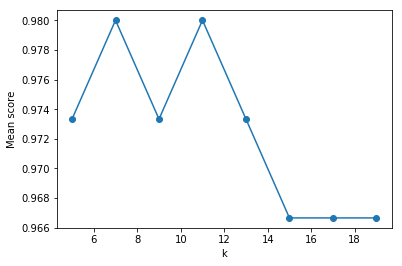

In [17]:
# plotting the mean score vs k
plt.plot(np.arange(5,20,2), meanScores, 'o-')
plt.xlabel('k')
plt.ylabel('Mean score')
plt.show()

Looks like k=7 is a good choice for this data set. You can search an optimal parameter this way.

Or, there is a tool called **`GridSearchCV`** under **`sklearn.model_selection`**. It performs cross validation for different values of parameters, and pick the best one for you. To use `GridSearchCV`, first you have to define combinations of parameter values to be examined.

In [18]:
# using a grid search
param = {'n_neighbors':list(range(5,20,2)),
         'weights':['uniform', 'distance']}

Here, possible values of parameters are stored in a *dictionary* called **`param`**. Notice that the parameter k's actual name is **`n_neighbors`**. We also need to define any other parameters that are not the default values in a classifier. In this case, we will examine **`weights`** to be either **`'uniform'`** or **`'distance'`**, just for fun. The next step is to define the classifier object.

In [19]:
kNN = KNeighborsClassifier()

Here, we don't have to worry about the parameters set in `param`. Now we have a classifier object and the parameter dictionary, we define the grid search object **`GridSearchCV`**.

In [20]:
grid_kNN = GridSearchCV(kNN, param, cv=5)
grid_kNN.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In the grid search object `GridSearchCV`, we need to provide the classifier object and the parameter dictionary. You can specify the number of folds to be used in cross validation as parameter **`cv`**. Here, we try 5-fold cross validation as before. Once the grid search object `GridSearchCV` is defined, then we use the **`fit`** to learn from the features and targets. Here, we provide the entire data set. Now let's see what the winning combination of the parameters was.

In [21]:
print(grid_kNN.best_params_)

{'n_neighbors': 11, 'weights': 'distance'}


So, this time, k=11 seems to be the winner (and `distance` weighting). And here is the mean accuracy score resulting from that combination.

In [22]:
print(grid_kNN.best_score_)

0.9866666666666667


And we can check the winning combination on another testing data set.


In [23]:
# Checking the winning combination
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=2018)
kNN = KNeighborsClassifier(7, weights='uniform')
kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred,
                            target_names=target_names))

[[24  0  0]
 [ 0 18  1]
 [ 0  1 16]]
             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        24
 versicolor       0.95      0.95      0.95        19
  virginica       0.94      0.94      0.94        17

avg / total       0.97      0.97      0.97        60



### Exercise
1. **Iris data, parameter search for SVM**. Say, you want to use a support vector machine (SVM) classifier instead to a kNN classifier on the iris data. Determine the best combination of parameters to use with a grid search with 5-fold cross validation. These are the possible values of the parameters:

  * **`C`**: `[10, 1.0, 0.1]`
  * **`kernel`**: `['linear', 'rbf', 'poly']`

  Print out the best parameter combination, and the mean score associated with that combination.

## Example: seed data

As you recall that the seed data features need to be standardized before cross validation. Thus, we had to create a pipeline of standardization and a classifier. If we want to perform a grid search on classifier parameters, we need to do the same. However, since the classifier has to be run under different combinations of parameters, we have to use **`Pipeline`** function under **`sklearn.pipeline`** to construct the pipeline. 

`<SeedGridSearch.py>`

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report


# loading the data 
seedData = pd.read_csv('seeds_dataset.txt', sep='\t', header=None)
seedFeatures = np.array(seedData.iloc[:,:7])
seedTargets = np.array(seedData.iloc[:,7]) - 1 # starting from zero
targetNames = ['Kama','Rosa','Canadian']

The pipeline object **`svm`** is created by **`Pipeline`** with a list of tuples (delimited by '(' & ')'), with each tuple containing a name you assign to a transformation object, and the object.  

In [28]:
# pipeline of transformations
svm = Pipeline([
    ('normalize',StandardScaler()),
    ('classify',SVC())
])

And parameters need to be specified as to which steps of the pipeline they are going to be used. Do do so, the name of the parameter has to be prefixed by the step name in the pipeline (e.g., `'classify'`) and two underscores (`__`). 

In [29]:
param = {'classify__C': [10,1,0.1],
         'classify__kernel': ['rbf','poly','linear']}

And you pass on the parameters under the **`param_grid`** parameter in the `GridSearchCV` object.

In [30]:
# grid search
grid_svm = GridSearchCV(svm, param_grid=param, cv=10)
grid_svm.fit(seedFeatures,seedTargets)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('normalize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classify__C': [10, 1, 0.1], 'classify__kernel': ['rbf', 'poly', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Let's see the winning combination.

In [31]:
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'classify__C': 10, 'classify__kernel': 'linear'}
0.9476190476190476


We can check the winning combination in another testing data set.

In [32]:
# Checking the winning combination
X_train, X_test, y_train, y_test = train_test_split(seedFeatures,
                                                    seedTargets, 
                                                    test_size=70, 
                                                    random_state=0)
normTrain = StandardScaler().fit(X_train)
X_train_norm = normTrain.transform(X_train)
X_test_norm = normTrain.transform(X_test)
sv = SVC(kernel='linear',C=10)
sv.fit(X_train_norm,y_train)
y_pred = sv.predict(X_test_norm)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred,
                            target_names=targetNames))

[[21  1  2]
 [ 2 26  0]
 [ 0  0 18]]
             precision    recall  f1-score   support

       Kama       0.91      0.88      0.89        24
       Rosa       0.96      0.93      0.95        28
   Canadian       0.90      1.00      0.95        18

avg / total       0.93      0.93      0.93        70

